# Modelling quarantine

Quarantine is a very common form of disease countermeasure. It works by reducing the connectivity of the contact network over which a disease moves, but &ndash; unlike more coarse measures like physical distancing &ndash; focuses on isolating the individuals known (or suspected) to be infected.

In this notebook we explore basic quarantine procedures.

In [1]:
# numpy
from numpy import linspace
from numpy.random import default_rng

# simulation
from epyc import Experiment, HDF5LabNotebook, ParallelLab
from epydemic import SIR, ERNetwork, PLCNetwork, StochasticDynamics, ProcessSequence, Monitor

# networks
import networkx
from collections import Counter

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

In [2]:
nb = HDF5LabNotebook(Path(datasets, "10-04-quarantine.h5"))

In [3]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

Current system has 8 cores in total


In [4]:
# pick the number of cores -- change this to change parallelism
nCores = 16

In [5]:
lab = ParallelLab(notebook=nb, cores=nCores)

## Quarantine as a process

The basic idea of quarantine is simple. When an individual becomes infected, we adapt the contact network surrounding them to reduce the number of contacts they have &ndash; and therefore the number of infection opportunities they present.

We need to be careful to think about the reality of situation we're modelling. In the real world, we will not identify *all* the infected people with precision; nor will we identify *all* their contacts. We can model these failings in several ways, but for now we will adopt the simplest approach. When an individual is infected, we visit all their neighbours and, if they are susceptible, decide with some probability whether to rewire the edge connecting. If we do, we rewire the SI edge to form an SS edge with some other randomly-chosen susceptible.

The choice probability is clearly doing a lot of work, modelling both the probability of detecting the infected individual and the ability to rewire connections. One could split this value in two and form the product of individual probabilities, to make the model match reality more closely: but the result would be the same.

In [6]:
class QuarantineSIR(SIR):
    
    P_REWIRE = 'pRewire'   #: Parameter for the probability of rewiring an SI edge.
    
    def __init__(self):
        super().__init__()
        
    def build(self, params):
        super().build(params)
        
        # store the parameters for later
        self._pRewire = params[self.P_REWIRE]

        # track the susceptible compartment for rewiring
        self.trackNodesInCompartment(SIR.SUSCEPTIBLE)

    def quarantine(self, n):
        '''Quarantine a node with a given probability.
        
        :param n: the node'''
        g = self.network()
        rng = default_rng()

        # run through all the neighbours of the infected node 
        ms = list(g.neighbors(n))
        for m in ms:
            if self.getCompartment(m) == self.SUSCEPTIBLE and rng.random() <= self._pRewire:
                # selected a susceptible neighbour to rewire,
                # remove its link to us
                self.removeEdge(n, m)
                
                # rewire to another random susceptible
                mprime = self.locus(self.SUSCEPTIBLE).draw()
                self.addEdge(m, mprime)
        
    def infect(self, t, e):
        '''Infection also performs quarantine on the newly-infected node.
        
        :param e: the edge'''
        (n, _) = e
        
        # perform a normal infection event
        super().infect(t, e)
        
        # quarantine the newly-infected node
        self.quarantine(n)  

In [7]:
def makeQuarantinePLC(N, alpha, cutoff,
                      pInfected, pInfect, pRemove, pRewire,
                      T, reps = None):
    
    def sir_q(lab):
        lab[SIR.P_INFECTED] = pInfected
        lab[SIR.P_INFECT] = pInfect
        lab[SIR.P_REMOVE] = pRemove
        lab[QuarantineSIR.P_REWIRE] = pRewire
        lab[PLCNetwork.N] = N
        lab[PLCNetwork.EXPONENT] = alpha
        lab[PLCNetwork.CUTOFF] = cutoff
        
        # sample the compartments every 50 timesteps
        lab[Monitor.DELTA] = T / 50

        # do repetitions if requested
        if reps is not None:
            lab['reps'] = range(reps)
            
        q = QuarantineSIR()
        q.setMaximumTime(T)
        m = ProcessSequence([q, Monitor()])
        e = StochasticDynamics(m, PLCNetwork())
        lab.runExperiment(e)
        
    return sir_q

We can explore the effects of this process on powerlaw-with-cutoff networks for different cutoffs. Let's start with the extrema: what happens when there is no rewiring, or when there is perfect reqiring? In the former case we would expect the disease to behave exactly like the baseline case without quarantine; in the latter we would expect the outbreak to fail completely as the individuals infected in the first wave of infection will have no opportunity to infect others.

In [8]:
# Network parameters
N = int(5e3)
alpha = 2
cutoffs = [10, 30, 40, 80]

# Simulation time
T = 1000

# Disease parameters
pInfected = 0.001
pInfect = 0.01
pRemove = 0.002

In [9]:
lab.createWith("sirq_plc_baseline",
               makeQuarantinePLC(N, alpha, cutoffs,
                                 pInfected, pInfect, pRemove, 0.0,
                                 T),
               "SIR baseline (no quarantine) on PLC networks")

True

In [10]:
lab.createWith("sirq_plc_perfect",
               makeQuarantinePLC(N, alpha, cutoffs,
                                 pInfected, pInfect, pRemove, 1.0,
                                 T),
               "SIR with perfect quarantine on PLC networks")

True

Plotting the baseline result gives a familiar set of diagrams.

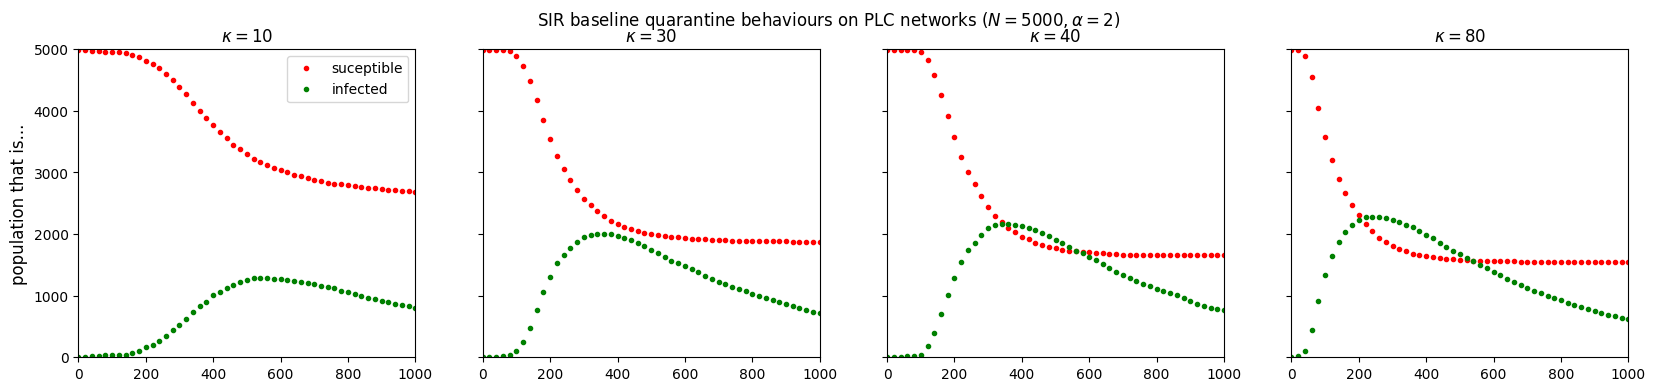

In [11]:
(fig, axs) = plt.subplots(1, len(cutoffs), sharey=True,
                          figsize=(5 * len(cutoffs), 4))

# no quarantine
nb.select("sirq_plc_baseline")
df = nb.dataframe()
for i in range(len(cutoffs)):
    ax = axs[i]
    cutoff = cutoffs[i]
    rc = df[df[PLCNetwork.CUTOFF] == cutoff]
    timeseries = rc.iloc[0]
    ts = timeseries[Monitor.OBSERVATIONS]
    sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
    iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]

    ax.plot(ts, sss, 'r.', label='suceptible')
    ax.plot(ts, iss, 'g.', label='infected')

    ax.set_xlim([0, T])
    ax.set_ylim([0, N])
    ax.set_title(f'$\\kappa = {cutoff}$')
    
# fine-tune figure
axs[0].set_ylabel('population that is...')
axs[0].legend(loc='upper right') 
fig.suptitle(f'SIR baseline quarantine behaviours on PLC networks ($N = {N},  \\alpha = {alpha}$)')

_ = plt.show()

While plotting the perfect case should be no surprise either.

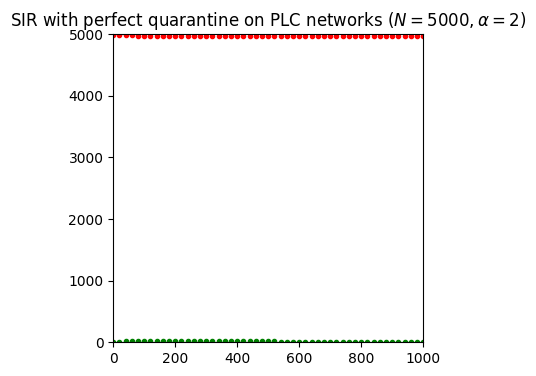

In [12]:
fig = plt.figure(figsize=(4, 4))
ax = plt.gca()

# perfect quarantine
nb.select("sirq_plc_perfect")
df = nb.dataframe()
cutoff = cutoffs[-1]
rc = df[df[PLCNetwork.CUTOFF] == cutoff]
timeseries = rc.iloc[0]
ts = timeseries[Monitor.OBSERVATIONS]
sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')

ax.set_xlim([0, T])
ax.set_ylim([0, N])
ax.set_title(f'$\\kappa = {cutoff}$')
ax.set_title(f'SIR with perfect quarantine on PLC networks ($N = {N},  \\alpha = {alpha}$)')

_ = plt.show()

## Outbreak size under quarantine

Let's now sweep through the space of possible quarantine efficiencies between these two extrema. We'll do repeated experiments at each point to account for the stochastic nature of the process.

In [13]:
reps = 10
pRewires = linspace(0.0, 1.0, num=100)

In [14]:
lab.createWith("sirq_plc_rewiring",
               makeQuarantinePLC(N, alpha, cutoffs,
                                 pInfected, pInfect, pRemove, pRewires,
                                 T, reps),
               "SIR with variable quarantine on PLC networks")

True

We can then plot the outbreak sizes against quarantine efficiency. Note that this is different to the diagrams above, where I plotted the S and I compartment sizes over time: in this case I'm plotting the final outbreak size only. We include both the raw data and the mean for the four different cutoff values.

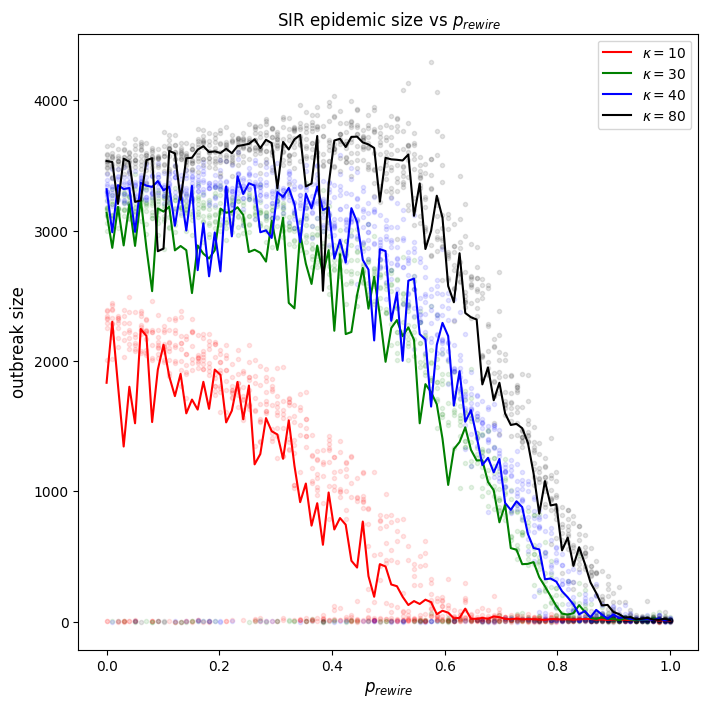

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
nb.select("sirq_plc_rewiring")
df =  lab.dataframe()
colours = ['r', 'g', 'b', 'k']
for i in range(len(cutoffs)):
    cutoff = cutoffs[i]
    dfc = df[df[PLCNetwork.CUTOFF] == cutoff]
    ax.scatter(dfc[QuarantineSIR.P_REWIRE], dfc[SIR.REMOVED],
               marker='.', color=colours[i], alpha=0.1,)

    rws = list(dfc[QuarantineSIR.P_REWIRE].unique())
    rws.sort()
    rs_mean = (dfc.groupby(QuarantineSIR.P_REWIRE))[SIR.REMOVED].mean()
    ax.plot(rws, rs_mean,
            color=colours[i], label=f'$\\kappa = {cutoff}$')

ax.set_xlabel('$p_{rewire}$')
ax.set_ylabel('outbreak size')
ax.legend(loc='upper right')
ax.set_title('SIR epidemic size vs $p_{rewire}}$')

_ = plt.show()

We can see that there is a lot of variance in the results, including zero-sized outbreaks across the range. We can see that low quarantine efficiency has essentially no effect on outbreak size. We need to be isolating a substantial number of contacts &ndash; between 40% and 60%  &ndash; before we start to see any meaningful decrease in outbreak size, especiaslly for densely-connected (high-$\kappa$) networks. This may have implications for real-world programmes.

There are other things we could explore about quarantine, starting with different network structures. But we would also want to understand how it works for models more complicated than SIR. Models such as SEIR that distinguish between asymptomatic and symptomatic phases of infection, are especially interesting: we can't quarantine exposed individuals since we can't easily detect them other that by explicit testing.